Firstly, What Policy can affect the transmission of COVID-19?

In [ ]:
import seaborn as sns
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import glob, os, datetime
from pathlib import Path

In [ ]:
#For the first time running this notebook, uncomment the next line and run this cell
!pip install reverse_geocoder
import reverse_geocoder as rg

     |████████████████████████████████| 2.3MB 6.6MB/s 
  Created wheel for reverse-geocoder: filename=reverse_geocoder-1.5.1-cp36-none-any.whl size=2268090 sha256=0e4b7de4eb9a29322c9e818ec68045a406838d1a556652f54abe1a860120d2e4
  Stored in directory: /root/.cache/pip/wheels/47/05/50/b1350ff094ef91e082665b4a2f9ca551f8acea4aa55d796b26
Successfully built reverse-geocoder


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
zf = zipfile.ZipFile('/content/drive/MyDrive/200Project/csse_covid_19_daily_reports_us.zip', 'r')
zf.extractall(Path(''))

In [ ]:
# Compile all daily covid datasets into one
all_covid_df = pd.DataFrame()

for filename in glob.glob("csse_covid_19_daily_reports_us/*.csv"):
  covid_df = pd.read_csv(filename)
  date = datetime.datetime.strptime(os.path.basename(filename)[:-4], '%m-%d-%Y')
  yesterday = (date - datetime.timedelta(1)).strftime('%m-%d-%Y')

  covid_df['Date'] = date
  covid_df = covid_df.drop(columns=['Country_Region', 'Lat', 'Long_', 'Last_Update', 'ISO3', 'UID', 'FIPS']).fillna(0)

  all_covid_df = pd.concat([all_covid_df, covid_df])

all_covid_df = all_covid_df.rename(columns={"Province_State": "State"})
# Clean data by dropping entries with state “Recover”
all_covid_df = all_covid_df.query("State != 'Recovered'")
all_covid_df.head()

,State,Confirmed,Deaths,Recovered,Active,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,Testing_Rate,Hospitalization_Rate,Date
0,Alabama,74212,1397,32510.0,40305.0,1513.546807,619527.0,8995.0,1.882445,12635.195286,12.120681,2020-07-23
1,Alaska,2193,19,787.0,1387.0,299.776500,189509.0,0.0,0.866393,25905.309995,0.000000,2020-07-23
2,American Samoa,0,0,0.0,0.0,0.000000,1037.0,0.0,0.000000,1863.733578,0.000000,2020-07-23
3,Arizona,152944,3063,19737.0,130144.0,2101.249437,822713.0,7236.0,2.002694,11302.994745,4.731143,2020-07-23
4,Arkansas,36259,386,28864.0,7009.0,1201.502815,446480.0,2361.0,1.064563,14794.864080,6.511487,2020-07-23


In [ ]:
# Add daily death, confirmed, tested based on state and date
covid_df_by_date_original = all_covid_df[['State', 'Confirmed', 'People_Tested', 'Deaths', 'Date']].groupby(['State', 'Date']).agg(sum)
covid_df_by_date_original = covid_df_by_date_original.diff().rename(columns={'Confirmed': 'Daily_Increase', 'People_Tested': 'Daily_Tested', 'Deaths': 'Daily_Deaths'})
covid_df_by_date_original.drop(covid_df_by_date_original[covid_df_by_date_original['Daily_Increase'] < 0].index, inplace=True)
covid_df_by_date_original.head()

Daily_Increase  Daily_Tested  Daily_Deaths
State   Date                                                  
Alabama 2020-04-12             NaN           NaN           NaN
        2020-04-13           171.0        7599.0           6.0
        2020-04-14           219.0        3935.0          15.0
        2020-04-15           122.0         960.0           4.0
        2020-04-16           270.0        2314.0          15.0

In [ ]:
# Merge daily data back to main df
daily_covid_df_original = all_covid_df.merge(covid_df_by_date_original, how = "inner", on=['State', 'Date']).sort_values(by=["State", "Date"])
daily_covid_df_original.head()

,State,Confirmed,Deaths,Recovered,Active,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,Testing_Rate,Hospitalization_Rate,Date,Daily_Increase,Daily_Tested,Daily_Deaths
2602,Alabama,3563,93,0.0,3470.0,75.988020,21583.0,437.0,2.610160,460.300152,12.264945,2020-04-12,NaN,NaN,NaN
8044,Alabama,3734,99,0.0,3635.0,79.634933,29182.0,457.0,2.651312,622.363852,12.238886,2020-04-13,171.0,7599.0,6.0
2670,Alabama,3953,114,0.0,3839.0,84.305541,33117.0,493.0,2.883886,706.285508,12.471541,2020-04-14,219.0,3935.0,15.0
8160,Alabama,4075,118,0.0,3957.0,86.907433,34077.0,525.0,2.895706,726.759406,12.883436,2020-04-15,122.0,960.0,4.0
10418,Alabama,4345,133,0.0,4212.0,92.665716,36391.0,553.0,3.060990,776.110032,12.727273,2020-04-16,270.0,2314.0,15.0


In [ ]:
# Add population column for each state
population_file_path='/content/drive/MyDrive/200Project/State Populations.csv'
population_df = pd.read_csv(population_file_path)

display(population_df.head())

covid_population_df_original = daily_covid_df_original.merge(population_df, how="inner", on='State')

covid_population_df_original.head()

,State,Population
0,California,39776830
1,Texas,28704330
2,Florida,21312211
3,New York,19862512
4,Pennsylvania,12823989


,State,Confirmed,Deaths,Recovered,Active,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,Testing_Rate,Hospitalization_Rate,Date,Daily_Increase,Daily_Tested,Daily_Deaths,Population
0,Alabama,3563,93,0.0,3470.0,75.988020,21583.0,437.0,2.610160,460.300152,12.264945,2020-04-12,NaN,NaN,NaN,4888949
1,Alabama,3734,99,0.0,3635.0,79.634933,29182.0,457.0,2.651312,622.363852,12.238886,2020-04-13,171.0,7599.0,6.0,4888949
2,Alabama,3953,114,0.0,3839.0,84.305541,33117.0,493.0,2.883886,706.285508,12.471541,2020-04-14,219.0,3935.0,15.0,4888949
3,Alabama,4075,118,0.0,3957.0,86.907433,34077.0,525.0,2.895706,726.759406,12.883436,2020-04-15,122.0,960.0,4.0,4888949
4,Alabama,4345,133,0.0,4212.0,92.665716,36391.0,553.0,3.060990,776.110032,12.727273,2020-04-16,270.0,2314.0,15.0,4888949


### EDA of COVID datasets

#### Difference in Mortality rates by states and time

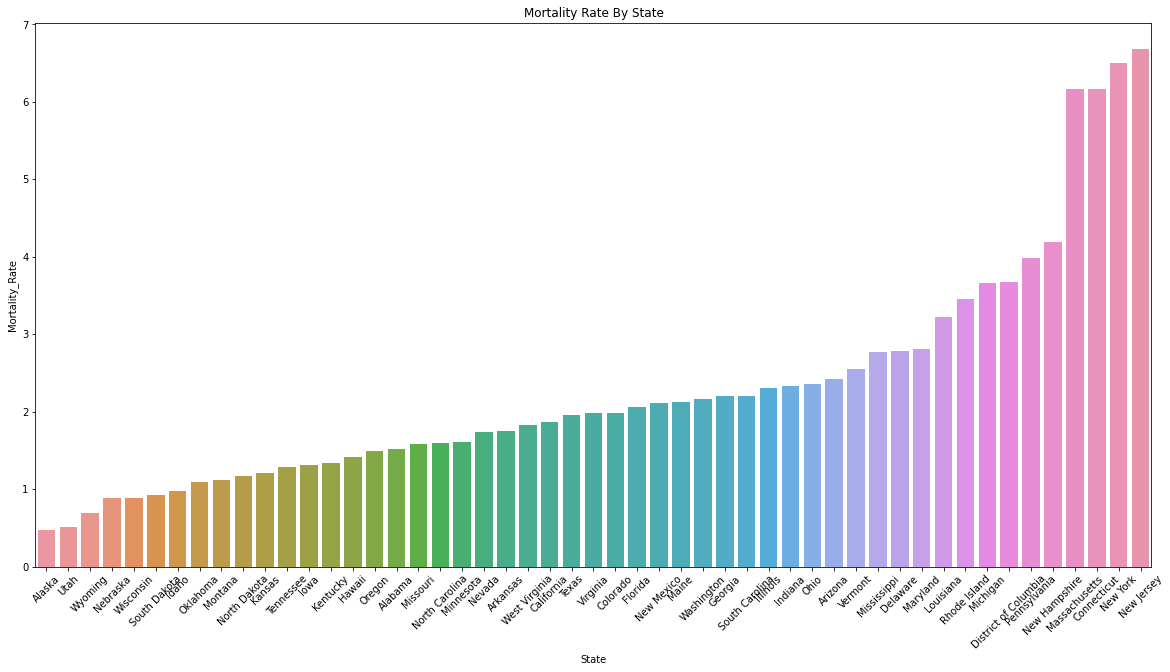

In [ ]:
# Mortality Rate By State

mortality_df = covid_population_df_original[['State', 'Mortality_Rate']][covid_population_df_original['Date'] == '2020-11-04'].sort_values(by='Mortality_Rate')

plt.figure (figsize=(20,10))
sns.barplot(data = mortality_df, x = 'State', y = 'Mortality_Rate');

plt.xticks(rotation=45)
plt.title('Mortality Rate By State')
plt.show()

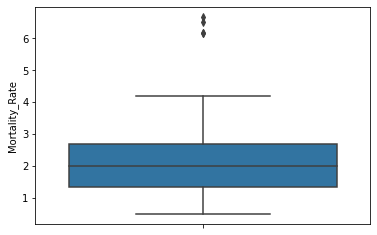

In [ ]:
sns.boxplot(data = mortality_df, y = 'Mortality_Rate');

# Outliers are those states with higher COVID-19 cases in the beginning of the pandemic

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


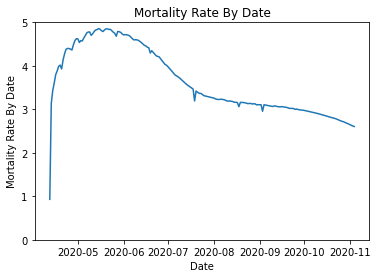

In [ ]:
# Mortality Rate By Date
mortality_time_df = covid_population_df_original[['Date', 'Mortality_Rate', 'Population']]
mortality_time_df['Mortality Rate By Date'] = mortality_time_df['Mortality_Rate'] * mortality_time_df['Population'] / population_df['Population'].sum()
mortality_time_df = mortality_time_df[['Date', 'Mortality Rate By Date']].groupby('Date').sum().reset_index()

sns.lineplot(data = mortality_time_df, x = 'Date', y = 'Mortality Rate By Date');

plt.title('Mortality Rate By Date')
plt.ylim([0, 5])
plt.show()

# This plot matches the conclusion above

In [ ]:
covid_population_df_original[covid_population_df_original['State']=='New York']

,State,Confirmed,Deaths,Recovered,Active,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,Testing_Rate,Hospitalization_Rate,Date,Daily_Increase,Daily_Tested,Daily_Deaths,Population
6575,New York,189033,9385,23887.0,179648.0,1121.124012,461601.0,42594.0,4.964742,2737.680538,22.532574,2020-04-12,138782.0,-740746.0,8326.0,19862512
6576,New York,195749,10058,23887.0,185691.0,1160.955517,478357.0,42712.0,5.138213,2837.057652,21.819779,2020-04-13,6716.0,16756.0,673.0,19862512
6577,New York,203020,10842,23887.0,192178.0,1204.078637,499143.0,46201.0,5.340361,2960.336041,22.756871,2020-04-14,7271.0,20786.0,784.0,19862512
6578,New York,214454,11617,23887.0,202837.0,1271.891833,526012.0,46201.0,5.417013,3119.691715,21.543548,2020-04-15,11434.0,26869.0,775.0,19862512
6579,New York,223691,14832,23887.0,208859.0,1326.674980,550579.0,50450.0,6.630575,3265.394601,22.553433,2020-04-16,9237.0,24567.0,3215.0,19862512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6777,New York,507543,33511,79717.0,394315.0,2608.997910,14527718.0,0.0,6.602593,74678.964946,0.000000,2020-10-31,2112.0,136962.0,5.0,19862512
6778,New York,509735,33535,79831.0,396369.0,2620.265770,14676653.0,0.0,6.578909,75444.557426,0.000000,2020-11-01,2192.0,148935.0,24.0,19862512
6779,New York,511368,33539,79831.0,397998.0,2628.660120,14772754.0,0.0,6.558682,75938.559526,0.000000,2020-11-02,1633.0,96101.0,4.0,19862512
6780,New York,513689,33543,79990.0,400156.0,2640.591098,14900623.0,0.0,6.529826,76595.863349,0.000000,2020-11-03,2321.0,127869.0,4.0,19862512


#### Correlation of Population and Daily Increase cases 

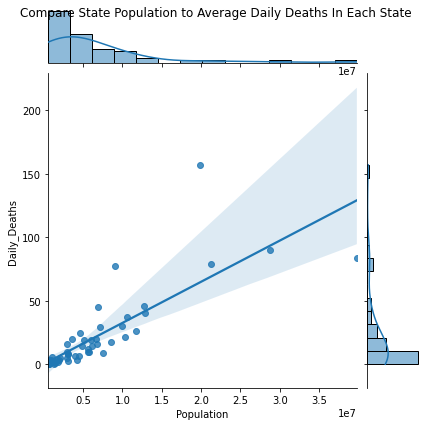

In [ ]:
daily_increase_population_df = covid_population_df_original[['State', 'Population', 'Daily_Deaths', 'Daily_Increase']].groupby(['State', 'Population']).mean().reset_index()
p = sns.jointplot(data = daily_increase_population_df, x = 'Population', y = 'Daily_Deaths', kind="reg");
p.fig.suptitle("Compare State Population to Average Daily Deaths In Each State")
plt.show()

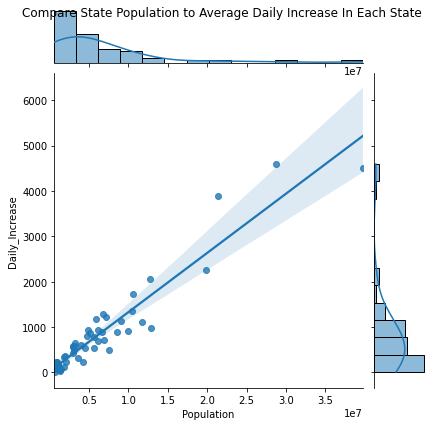

In [ ]:
p = sns.jointplot(data = daily_increase_population_df, x = 'Population', y = 'Daily_Increase', kind="reg");
p.fig.suptitle("Compare State Population to Average Daily Increase In Each State")
plt.show()


In [ ]:
# plt.figure (figsize=(12,5))
# sns.lineplot(data = covid_population_df_original, x = 'Active', y = 'Deaths', hue = 'State');
# sns.lineplot(data = covid_population_df_original, x = 'Date', y = 'Daily_Deaths', hue = 'State');
# [REMOVE from final report] This graph is overplotted.  

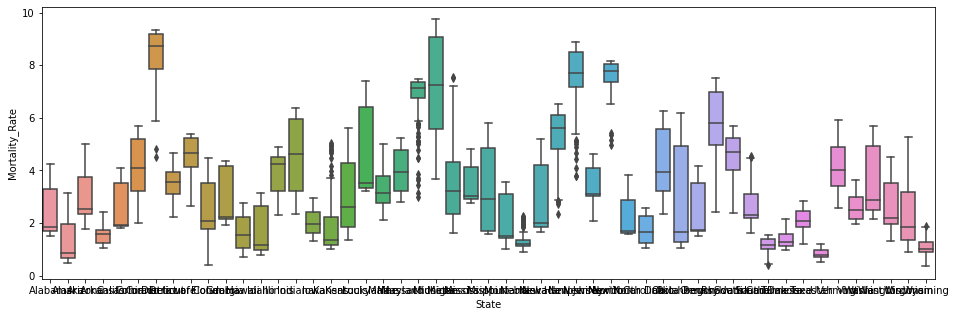

In [ ]:
# We now study the death rate 
plt.figure (figsize=(16,5))
sns.boxplot(data=covid_population_df_original, x='State', y = 'Mortality_Rate');
# This graph also shows that each state has a significantly different mortality rate
# [REMOVE from final report] Use the barplot instead.  

### Effects of policies and COVID

#### Explore the relationship between COVID and Party

In [ ]:
# Add party column (0: Democrat, 1: Republican) -- binary
republican_2020 = ['Texas', 'Florida', 'Ohio', 'North Carolina', 'Indiana', 'Tennessee', 'Missouri', 'Alabama', 'South Carolina', 'Kentucky', 'Louisiana', 'Oklahoma', 'Mississippi', 'Iowa', 'Arkansas', 'Kansas', 'Utah', 'West Virginia', 'Idaho', 'Nebraska', 'Alaska', 'Montana', 'North Dakota', 'South Dakota', 'Wyoming']

covid_population_df_original['Republican'] = covid_population_df_original['State'].isin(republican_2020)
covid_population_df_original['Republican'] = covid_population_df_original['Republican'].replace({True: 1, False: 0})

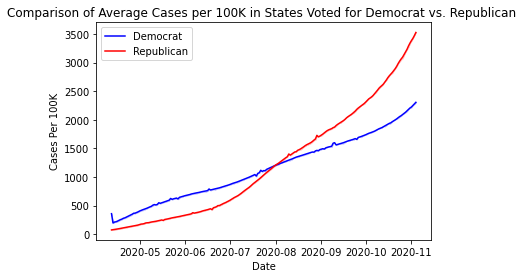

In [ ]:
# Does party influence the number of confirmed COVID cases? To avoid population of each state skewing the data, we use the "Cases per 100K"
covid_population_df_original['Cases Per 100K'] = covid_population_df_original['Confirmed'] / covid_population_df_original['Population'] * 100000
sns.lineplot(data = covid_population_df_original[covid_population_df_original['Republican'] == 0], x = 'Date', y = 'Cases Per 100K', ci = False, color = 'blue');
sns.lineplot(data = covid_population_df_original[covid_population_df_original['Republican'] == 1], x = 'Date', y = 'Cases Per 100K', ci = False, color = 'r');
plt.legend(['Democrat', 'Republican'])
plt.title('Comparison of Average Cases per 100K in States Voted for Democrat vs. Republican ')
plt.show()
# After August, the confirmed cases of republican states exceeds those of democratic states

#### Explore the relationship between COVID and State Restrictions

##### Mask

In [ ]:
# Add mask column (0: No restrictions, 1: Sometimes required, 2: Mandatory) 
no_restrictions = ['Wyoming', 'South Dakota', 'Montana', 'Oklahoma', 'Tennessee', 'Georgia', 'Florida', 'Idaho']
sometimes = ['Arizona', 'Nebraska', 'Kansas', 'Arkansas', 'Mississippi', 'South Carolina']

covid_politics_df_original = covid_population_df_original.assign(Mask = lambda x: covid_population_df_original['State'].isin(no_restrictions))
covid_politics_df_original['Mask'] = covid_politics_df_original['Mask'].replace({False: 'Other', True: 'No restrictions'})
covid_politics_df_original[covid_politics_df_original['Mask'] == 'Other'] = covid_politics_df_original[covid_politics_df_original['Mask'] == 'Other'].assign(Mask = lambda x: covid_politics_df_original['State'].isin(sometimes))
covid_politics_df_original['Mask'] = covid_politics_df_original['Mask'].replace({False: 2, True: 1, 'No restrictions': 0})

covid_politics_df_original.head()


,State,Confirmed,Deaths,Recovered,Active,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,Testing_Rate,Hospitalization_Rate,Date,Daily_Increase,Daily_Tested,Daily_Deaths,Population,Republican,Cases Per 100K,Mask
0,Alabama,3563,93,0.0,3470.0,75.988020,21583.0,437.0,2.610160,460.300152,12.264945,2020-04-12,NaN,NaN,NaN,4888949,1,72.878649,2
1,Alabama,3734,99,0.0,3635.0,79.634933,29182.0,457.0,2.651312,622.363852,12.238886,2020-04-13,171.0,7599.0,6.0,4888949,1,76.376334,2
2,Alabama,3953,114,0.0,3839.0,84.305541,33117.0,493.0,2.883886,706.285508,12.471541,2020-04-14,219.0,3935.0,15.0,4888949,1,80.855824,2
3,Alabama,4075,118,0.0,3957.0,86.907433,34077.0,525.0,2.895706,726.759406,12.883436,2020-04-15,122.0,960.0,4.0,4888949,1,83.351248,2
4,Alabama,4345,133,0.0,4212.0,92.665716,36391.0,553.0,3.060990,776.110032,12.727273,2020-04-16,270.0,2314.0,15.0,4888949,1,88.873907,2


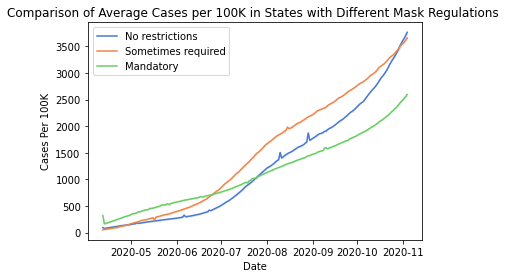

In [ ]:
sns.lineplot(data = covid_politics_df_original, x = 'Date', y = 'Cases Per 100K', hue = 'Mask', palette=sns.color_palette("muted", 3), ci=False);
plt.legend(['No restrictions', 'Sometimes required', 'Mandatory'])
plt.title('Comparison of Average Cases per 100K in States with Different Mask Regulations ')
plt.show()

# Can see some patterns here. Mask required states have fewer cases per 100K, while the difference between "sometimes required" and "no restrictions" is not obvious.

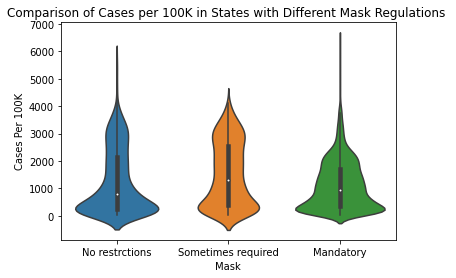

In [ ]:
# Does the regulation on masks influence the confirmed COVID cases?
g = sns.violinplot(data=covid_politics_df_original, x = 'Mask', y = 'Cases Per 100K');
plt.title('Comparison of Cases per 100K in States with Different Mask Regulations ')
g.set_xticklabels(["No restrctions", "Sometimes required", "Mandatory"]);
# Not too much

#####Businesses

In [ ]:
# Add business column (0: Mostly Open, 1: Mixed, 2: Mostly Closed)
mostly_closed = ['Washington', 'Oregon', 'New Mexico', 'Minnesota', 'Michigan', 'Illinois', 'Kentucky']
mixed = ['California', 'Arizona', 'Idaho', 'Colorado', 'Louisiana', 'North Carolina', 'New York', 'Maine', 'Vermont', 'Massachusetts', 'Connecticut']

covid_politics_df_original = covid_politics_df_original.assign(Businesses = lambda x: covid_politics_df_original['State'].isin(mostly_closed))
covid_politics_df_original['Businesses'] = covid_politics_df_original['Businesses'].replace({False: 'Other', True: 'Mostly Closed'})
covid_politics_df_original[covid_politics_df_original['Businesses'] == 'Other'] = covid_politics_df_original[covid_politics_df_original['Businesses'] == 'Other'].assign(Businesses = lambda x: covid_politics_df_original['State'].isin(mixed))
covid_politics_df_original['Businesses'] = covid_politics_df_original['Businesses'].replace({False: 0, True: 1, 'Mostly Closed': 2})


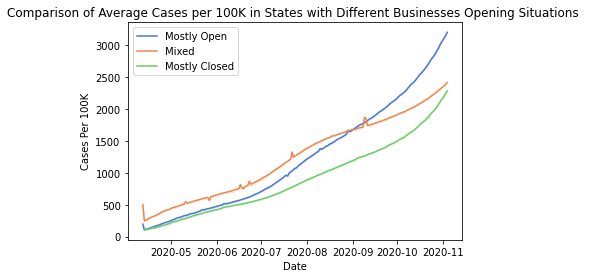

In [ ]:
sns.lineplot(data = covid_politics_df_original, x = 'Date', y = 'Cases Per 100K', hue = 'Businesses', palette=sns.color_palette("muted", 3), ci = False);
plt.legend(['Mostly Open', 'Mixed', 'Mostly Closed'])
plt.title('Comparison of Average Cases per 100K in States with Different Businesses Opening Situations ')
plt.show()

# Some differences here

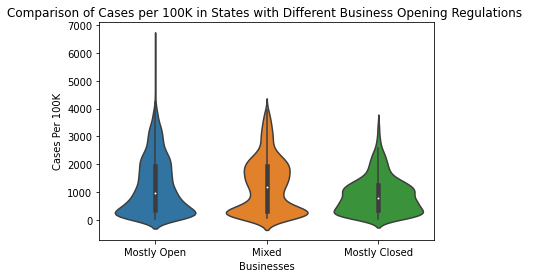

In [ ]:
g= sns.violinplot(data=covid_politics_df_original, x = 'Businesses', y = 'Cases Per 100K');
plt.title('Comparison of Cases per 100K in States with Different Business Opening Regulations ')
g.set_xticklabels(["Mostly Open", "Mixed", "Mostly Closed"]);

##### Stay At Home

In [ ]:
# Add Stay-at-home column (0: No restrictions, 1: Advisory, 2: Order for curfew)
order = ['California', 'Ohio']
advisory = ['New Mexiso', 'Wisconsin', 'Kentucky', 'Massachusetts']

covid_politics_df_original = covid_politics_df_original.assign(StayAtHome = lambda x: covid_politics_df_original['State'].isin(order))
covid_politics_df_original['StayAtHome'] = covid_politics_df_original['StayAtHome'].replace({False: 'Other', True: 'Order'})
covid_politics_df_original[covid_politics_df_original['StayAtHome'] == 'Other'] = covid_politics_df_original[covid_politics_df_original['StayAtHome'] == 'Other'].assign(StayAtHome = lambda x: covid_politics_df_original['State'].isin(advisory))
covid_politics_df_original['StayAtHome'] = covid_politics_df_original['StayAtHome'].replace({False: 0, True: 1, 'Order': 2})


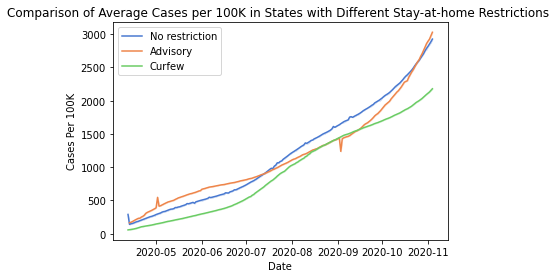

In [ ]:
sns.lineplot(data = covid_politics_df_original, x = 'Date', y = 'Cases Per 100K', hue = 'StayAtHome', palette=sns.color_palette("muted", 3), ci = False);
plt.legend(['No restriction', 'Advisory', 'Curfew'])
plt.title('Comparison of Average Cases per 100K in States with Different Stay-at-home Restrictions ')
plt.show()

# No much difference

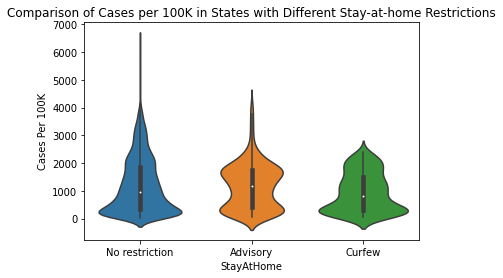

In [ ]:
g = sns.violinplot(data=covid_politics_df_original, x = 'StayAtHome', y = 'Cases Per 100K');
plt.title('Comparison of Cases per 100K in States with Different Stay-at-home Restrictions')
g.set_xticklabels(['No restriction', 'Advisory', 'Curfew']);
# As we can see, states with no strict stay at home policies usually have more cases per 100k

## Climate




In [ ]:
#load climate dataset
climate_df = pd.read_csv('/content/drive/MyDrive/200Project/daily_global_weather_2020.csv')
climate_df = climate_df.dropna()

In [ ]:
# group climate data into states and date
query = rg.search([tuple(x) for x in climate_df[['Latitude', 'Longitude']].values])
climate_geo = pd.DataFrame(query)

Loading formatted geocoded file...


In [ ]:
climate_all = pd.concat([climate_df, climate_geo], axis=1)
climate_all = climate_all[climate_all['cc'] == 'US']
climate_all = climate_all.drop(columns=['lat', 'lon','cc','Unnamed: 0'])
climate_all = climate_all.rename(columns={"name" : "Station_Name", "admin1" : "State", "admin2" : "County"})

In [ ]:
ordered_climate = climate_all.groupby(["State", "Date"], as_index=False).mean()
ordered_climate['Date'] = ordered_climate['Date'].astype('datetime64[ns]')
ordered_climate.head()

,State,Date,TAVG,Latitude,Longitude,Elevation,PRCP
0,Alabama,2020-01-02,115.8,32.87338,-86.992,134.98,442.6
1,Alabama,2020-01-03,167.8,32.87338,-86.992,134.98,257.4
2,Alabama,2020-01-04,129.0,32.87338,-86.992,134.98,6.2
3,Alabama,2020-01-05,57.6,32.87338,-86.992,134.98,0.0
4,Alabama,2020-01-06,90.4,32.87338,-86.992,134.98,1.6


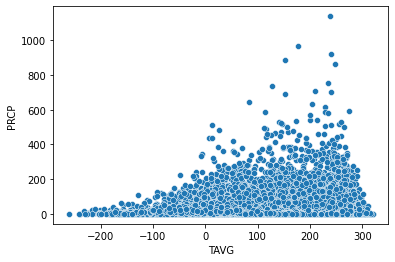

In [ ]:
sns.scatterplot(data = ordered_climate, x = 'TAVG', y = 'PRCP')
# there shows no strong correlation between TAVG and PRCP, thus they are two possibly viable features to use in the final model

In [ ]:
# Assign each state into a climate region
Central = 'Central,Illinois (IL),Indiana (IN),Kentucky (KY),Missouri (MO),Ohio (OH),Tennessee (TN),West Virginia (WV)'
East_North_Central = 'East_North_Central,Iowa (IA),Michigan (MI),Minnesota (MN),Wisconsin (WI)'
Northeast = 'Northeast,Connecticut (CT),Delaware (DE),Maine (ME),Maryland (MD),Massachusetts (MA),New Hampshire (NH),New Jersey (NJ),New York (NY),Pennsylvania (PA),Rhode Island (RI),Vermont (VT)'
Northwest ='Northwest,Idaho (ID),Oregon (OR),Washington (WA),Alaska (AK)'
South = 'South,Arkansas (AR),Kansas (KS),Louisiana (LA),Mississippi (MS),Oklahoma (OK),Texas (TX)'
Southeast = 'Southeast,Alabama (AL),Florida (FL),Georgia (GA),North Carolina (NC),South Carolina (SC),Virginia (VA)'
Southwest = 'Southwest,Arizona (AZ),Colorado (CO),New Mexico (NM),Utah (UT)'
West = 'West,California (CA),Nevada (NV),Hawaii (HI)'
West_North_Central = 'West_North_Central,Montana (MT),Nebraska (NE),North Dakota (ND),South Dakota (SD),Wyoming (WY)'

region = [Central, East_North_Central, Northeast, Northwest, South, Southeast, Southwest, West, West_North_Central]

region_d = {}
for i in region:
  i = i.split(',')
  region_d[i[0]] = i[1:]

region_dict = {}
for k,v in region_d.items():
  l = []
  for i in v:
    region_dict[i[:-5]] = k
  region_dict[k]=l

ordered_climate["climate_region"] = ordered_climate["State"].map(region_dict)

In [ ]:
ordered_climate.head()

,State,Date,TAVG,Latitude,Longitude,Elevation,PRCP,climate_region
0,Alabama,2020-01-02,115.8,32.87338,-86.992,134.98,442.6,Southeast
1,Alabama,2020-01-03,167.8,32.87338,-86.992,134.98,257.4,Southeast
2,Alabama,2020-01-04,129.0,32.87338,-86.992,134.98,6.2,Southeast
3,Alabama,2020-01-05,57.6,32.87338,-86.992,134.98,0.0,Southeast
4,Alabama,2020-01-06,90.4,32.87338,-86.992,134.98,1.6,Southeast


In [ ]:
# merge the climate and covid dataset together

combined_original = covid_politics_df_original.merge(ordered_climate, on=["State", "Date"]).sort_values(by=["State", "Date"])

combined_original.head()

,State,Confirmed,Deaths,Recovered,Active,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,Testing_Rate,Hospitalization_Rate,Date,Daily_Increase,Daily_Tested,Daily_Deaths,Population,Republican,Cases Per 100K,Mask,Businesses,StayAtHome,TAVG,Latitude,Longitude,Elevation,PRCP,climate_region
0,Alabama,3563,93,0.0,3470.0,75.988020,21583.0,437.0,2.610160,460.300152,12.264945,2020-04-12,NaN,NaN,NaN,4888949,1,72.878649,2,0,0,175.0,32.87338,-86.992,134.98,425.6,Southeast
1,Alabama,3734,99,0.0,3635.0,79.634933,29182.0,457.0,2.651312,622.363852,12.238886,2020-04-13,171.0,7599.0,6.0,4888949,1,76.376334,2,0,0,192.0,32.87338,-86.992,134.98,3.0,Southeast
2,Alabama,3953,114,0.0,3839.0,84.305541,33117.0,493.0,2.883886,706.285508,12.471541,2020-04-14,219.0,3935.0,15.0,4888949,1,80.855824,2,0,0,131.2,32.87338,-86.992,134.98,0.0,Southeast
3,Alabama,4075,118,0.0,3957.0,86.907433,34077.0,525.0,2.895706,726.759406,12.883436,2020-04-15,122.0,960.0,4.0,4888949,1,83.351248,2,0,0,114.6,32.87338,-86.992,134.98,0.0,Southeast
4,Alabama,4345,133,0.0,4212.0,92.665716,36391.0,553.0,3.060990,776.110032,12.727273,2020-04-16,270.0,2314.0,15.0,4888949,1,88.873907,2,0,0,127.8,32.87338,-86.992,134.98,0.0,Southeast


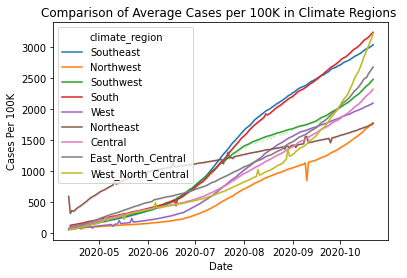

In [ ]:
sns.lineplot(data = combined_original, x = 'Date', y = 'Cases Per 100K', hue = 'climate_region', ci=False)
plt.title('Comparison of Average Cases per 100K in Climate Regions ')
plt.show()

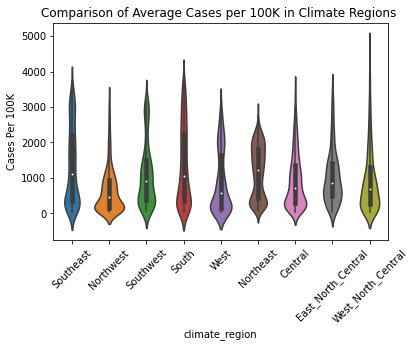

In [ ]:
# Does climate region has an effect on the Cases Per 100K
sns.violinplot(data = combined_original, x = 'climate_region', y = 'Cases Per 100K')
plt.title('Comparison of Average Cases per 100K in Climate Regions ')
plt.xticks(rotation=45)
plt.show()

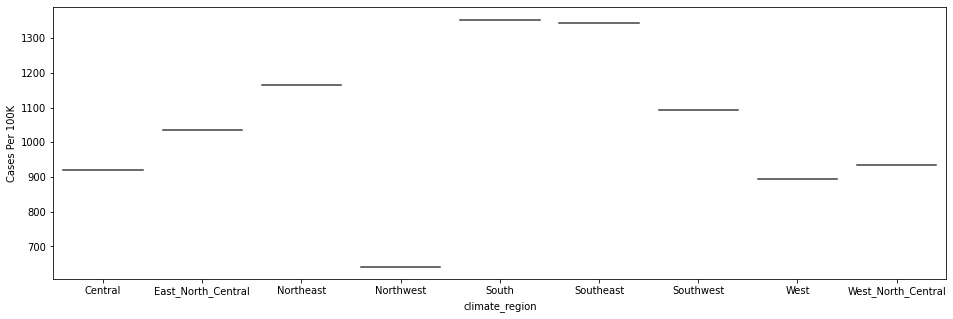

In [ ]:
region_study_df = combined_original.groupby('climate_region', as_index=False).mean()
region_study_df.head()
plt.figure (figsize=(16,5))
sns.violinplot(data = region_study_df, x = 'climate_region', y = 'Cases Per 100K')
#TODO: design a better graph, but it seems there are some association with cliamte regions

In [ ]:
# sns.scatterplot(data = combimed_original, x = 'TAVG', y = 'Daily_Increase')
# there shows no correlation

# TODO: binarize TAVG and PRCP, then show boxplot/violinplot if there is any difference of Daily_Increase in each bins
#sns.boxplot(data=combined, x='TAVG', y='Daily_Increase')

climate_buckets_df = combined_original[['Date', 'TAVG', 'PRCP', 'Cases Per 100K']]
climate_buckets_df['TAVG']=pd.qcut(combined_original['TAVG'], 4, labels=[1,2,3,4])
climate_buckets_df['PRCP']=pd.qcut(combined_original['PRCP'], 4, labels=[1,2,3], duplicates='drop')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


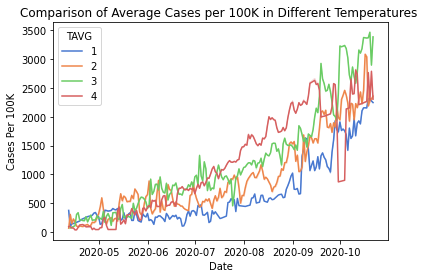

In [ ]:
sns.lineplot(data = climate_buckets_df, x = 'Date', y = 'Cases Per 100K', hue = 'TAVG', palette=sns.color_palette("muted", 4), ci=False);
plt.title('Comparison of Average Cases per 100K in Different Temperatures ')
plt.show()

# We can see that cases per 100K is lower in low temperature

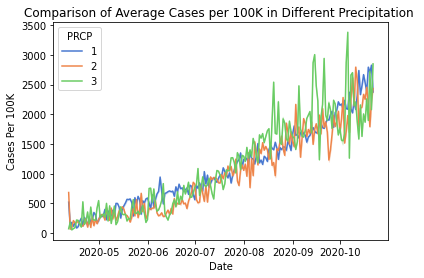

In [ ]:
sns.lineplot(data = climate_buckets_df, x = 'Date', y = 'Cases Per 100K', hue = 'PRCP', palette=sns.color_palette("muted", 3), ci=True);
plt.title('Comparison of Average Cases per 100K in Different Precipitation ')
plt.show()

# No correlation at all lol

In [ ]:
#sns.scatterplot(data=combined_original, x = 'PRCP', y = 'Daily_Increase');
#Similar to the plots with TAVG

In [ ]:
# Binarize columns Daily_Increase, Daily_Tested, Daily_Deaths for classification model
# 0 represents decrease in confirmed cases compared to previous date, 1 represents increase

combined = combined_original.copy()
combined[['Daily_Increase', 'Daily_Tested', 'Daily_Deaths']] = combined_original[['Daily_Increase', 'Daily_Tested', 'Daily_Deaths']].diff()
for col in ['Daily_Increase', 'Daily_Tested', 'Daily_Deaths']:
  combined.loc[combined[col] > 0, [col]] = 1
  combined.loc[combined[col] < 0, [col]] = 0
combined.head()

,State,Confirmed,Deaths,Recovered,Active,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,Testing_Rate,Hospitalization_Rate,Date,Daily_Increase,Daily_Tested,Daily_Deaths,Population,Republican,Cases Per 100K,Mask,Businesses,TAVG,Latitude,Longitude,Elevation,PRCP,climate_region
0,Alabama,3563,93,0.0,3470.0,75.988020,21583.0,437.0,2.610160,460.300152,12.264945,2020-04-12,NaN,NaN,NaN,4888949,1,72.878649,2,0,175.0,32.87338,-86.992,134.98,425.6,Southeast
1,Alabama,3734,99,0.0,3635.0,79.634933,29182.0,457.0,2.651312,622.363852,12.238886,2020-04-13,NaN,NaN,NaN,4888949,1,76.376334,2,0,192.0,32.87338,-86.992,134.98,3.0,Southeast
2,Alabama,3953,114,0.0,3839.0,84.305541,33117.0,493.0,2.883886,706.285508,12.471541,2020-04-14,1.0,0.0,1.0,4888949,1,80.855824,2,0,131.2,32.87338,-86.992,134.98,0.0,Southeast
3,Alabama,4075,118,0.0,3957.0,86.907433,34077.0,525.0,2.895706,726.759406,12.883436,2020-04-15,0.0,0.0,0.0,4888949,1,83.351248,2,0,114.6,32.87338,-86.992,134.98,0.0,Southeast
4,Alabama,4345,133,0.0,4212.0,92.665716,36391.0,553.0,3.060990,776.110032,12.727273,2020-04-16,1.0,1.0,1.0,4888949,1,88.873907,2,0,127.8,32.87338,-86.992,134.98,0.0,Southeast


In [ ]:
# climate region encoding
y = pd.get_dummies(combined.climate_region, prefix='climate')
encoded_combined = pd.concat([combined, y], axis = 1)

encoded_combined

,State,Confirmed,Deaths,Recovered,Active,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,Testing_Rate,Hospitalization_Rate,Date,Daily_Increase,Daily_Tested,Daily_Deaths,Population,Republican,Cases Per 100K,Mask,Businesses,TAVG,Latitude,Longitude,Elevation,PRCP,climate_region,climate_Central,climate_East_North_Central,climate_Northeast,climate_Northwest,climate_South,climate_Southeast,climate_Southwest,climate_West,climate_West_North_Central
0,Alabama,3563,93,0.0,3470.0,75.988020,21583.0,437.0,2.610160,460.300152,12.264945,2020-04-12,NaN,NaN,NaN,4888949,1,72.878649,2,0,175.000000,32.873380,-86.992000,134.980000,425.600000,Southeast,0,0,0,0,0,1,0,0,0
1,Alabama,3734,99,0.0,3635.0,79.634933,29182.0,457.0,2.651312,622.363852,12.238886,2020-04-13,NaN,NaN,NaN,4888949,1,76.376334,2,0,192.000000,32.873380,-86.992000,134.980000,3.000000,Southeast,0,0,0,0,0,1,0,0,0
2,Alabama,3953,114,0.0,3839.0,84.305541,33117.0,493.0,2.883886,706.285508,12.471541,2020-04-14,1.0,0.0,1.0,4888949,1,80.855824,2,0,131.200000,32.873380,-86.992000,134.980000,0.000000,Southeast,0,0,0,0,0,1,0,0,0
3,Alabama,4075,118,0.0,3957.0,86.907433,34077.0,525.0,2.895706,726.759406,12.883436,2020-04-15,0.0,0.0,0.0,4888949,1,83.351248,2,0,114.600000,32.873380,-86.992000,134.980000,0.000000,Southeast,0,0,0,0,0,1,0,0,0
4,Alabama,4345,133,0.0,4212.0,92.665716,36391.0,553.0,3.060990,776.110032,12.727273,2020-04-16,1.0,1.0,1.0,4888949,1,88.873907,2,0,127.800000,32.873380,-86.992000,134.980000,0.000000,Southeast,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9620,Wyoming,9025,57,6627.0,2341.0,1559.370999,117779.0,0.0,0.631579,20350.266691,0.000000,2020-10-18,1.0,1.0,0.0,573720,1,1573.067001,0,0,30.428571,42.912377,-108.457790,2612.172619,42.178571,West_North_Central,0,0,0,0,0,0,0,0,1
9621,Wyoming,9311,57,6796.0,2458.0,1608.787077,118065.0,0.0,0.612179,20399.682770,0.000000,2020-10-19,1.0,1.0,0.0,573720,1,1622.917102,0,0,40.987500,42.913996,-108.364805,2612.670000,22.362500,West_North_Central,0,0,0,0,0,0,0,0,1
9622,Wyoming,9526,61,6944.0,2521.0,1645.935528,118280.0,0.0,0.640353,20436.831220,0.000000,2020-10-20,0.0,0.0,1.0,573720,1,1660.391829,0,0,48.000000,42.941848,-108.459807,2602.880247,18.037037,West_North_Central,0,0,0,0,0,0,0,0,1
9623,Wyoming,9848,61,7070.0,2717.0,1701.571811,121670.0,0.0,0.619415,21022.567252,0.000000,2020-10-21,1.0,1.0,0.0,573720,1,1716.516768,0,0,41.424658,43.090407,-108.475814,2601.030137,8.863014,West_North_Central,0,0,0,0,0,0,0,0,1


In [ ]:
# Dropping all the features we are not considering and all the rows that contain NaN here
clean_combined_encoded_df = encoded_combined.drop(['Deaths', 'Recovered', 'People_Tested', 'People_Hospitalized', 'climate_region', 'Hospitalization_Rate', 'Mortality_Rate', 'Testing_Rate', 'Incident_Rate'], axis = 1).dropna()
clean_combined_encoded_df.head()

,State,Confirmed,Active,Date,Daily_Increase,Daily_Tested,Daily_Deaths,Population,Republican,Cases Per 100K,Mask,Businesses,TAVG,Latitude,Longitude,Elevation,PRCP,climate_Central,climate_East_North_Central,climate_Northeast,climate_Northwest,climate_South,climate_Southeast,climate_Southwest,climate_West,climate_West_North_Central
2,Alabama,3953,3839.0,2020-04-14,1.0,0.0,1.0,4888949,1,80.855824,2,0,131.2,32.87338,-86.992,134.98,0.0,0,0,0,0,0,1,0,0,0
3,Alabama,4075,3957.0,2020-04-15,0.0,0.0,0.0,4888949,1,83.351248,2,0,114.6,32.87338,-86.992,134.98,0.0,0,0,0,0,0,1,0,0,0
4,Alabama,4345,4212.0,2020-04-16,1.0,1.0,1.0,4888949,1,88.873907,2,0,127.8,32.87338,-86.992,134.98,0.0,0,0,0,0,0,1,0,0,0
5,Alabama,4571,4423.0,2020-04-17,0.0,0.0,0.0,4888949,1,93.496578,2,0,159.0,32.87338,-86.992,134.98,3.6,0,0,0,0,0,1,0,0,0
6,Alabama,4712,4559.0,2020-04-18,0.0,1.0,0.0,4888949,1,96.380633,2,0,184.6,32.87338,-86.992,134.98,38.6,0,0,0,0,0,1,0,0,0


In [ ]:
clean_combined_encoded_df.isnull().any()

State                         False
Confirmed                     False
Active                        False
Date                          False
Daily_Increase                False
Daily_Tested                  False
Daily_Deaths                  False
Population                    False
Republican                    False
Cases Per 100K                False
Mask                          False
Businesses                    False
TAVG                          False
Latitude                      False
Longitude                     False
Elevation                     False
PRCP                          False
climate_Central               False
climate_East_North_Central    False
climate_Northeast             False
climate_Northwest             False
climate_South                 False
climate_Southeast             False
climate_Southwest             False
climate_West                  False
climate_West_North_Central    False
dtype: bool

In [ ]:
clean_combined_encoded_df

,State,Confirmed,Active,Date,Daily_Increase,Daily_Tested,Daily_Deaths,Population,Republican,Cases Per 100K,Mask,Businesses,TAVG,Latitude,Longitude,Elevation,PRCP,climate_Central,climate_East_North_Central,climate_Northeast,climate_Northwest,climate_South,climate_Southeast,climate_Southwest,climate_West,climate_West_North_Central
2,Alabama,3953,3839.0,2020-04-14,1.0,0.0,1.0,4888949,1,80.855824,2,0,131.200000,32.873380,-86.992000,134.980000,0.000000,0,0,0,0,0,1,0,0,0
3,Alabama,4075,3957.0,2020-04-15,0.0,0.0,0.0,4888949,1,83.351248,2,0,114.600000,32.873380,-86.992000,134.980000,0.000000,0,0,0,0,0,1,0,0,0
4,Alabama,4345,4212.0,2020-04-16,1.0,1.0,1.0,4888949,1,88.873907,2,0,127.800000,32.873380,-86.992000,134.980000,0.000000,0,0,0,0,0,1,0,0,0
5,Alabama,4571,4423.0,2020-04-17,0.0,0.0,0.0,4888949,1,93.496578,2,0,159.000000,32.873380,-86.992000,134.980000,3.600000,0,0,0,0,0,1,0,0,0
6,Alabama,4712,4559.0,2020-04-18,0.0,1.0,0.0,4888949,1,96.380633,2,0,184.600000,32.873380,-86.992000,134.980000,38.600000,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9620,Wyoming,9025,2341.0,2020-10-18,1.0,1.0,0.0,573720,1,1573.067001,0,0,30.428571,42.912377,-108.457790,2612.172619,42.178571,0,0,0,0,0,0,0,0,1
9621,Wyoming,9311,2458.0,2020-10-19,1.0,1.0,0.0,573720,1,1622.917102,0,0,40.987500,42.913996,-108.364805,2612.670000,22.362500,0,0,0,0,0,0,0,0,1
9622,Wyoming,9526,2521.0,2020-10-20,0.0,0.0,1.0,573720,1,1660.391829,0,0,48.000000,42.941848,-108.459807,2602.880247,18.037037,0,0,0,0,0,0,0,0,1
9623,Wyoming,9848,2717.0,2020-10-21,1.0,1.0,0.0,573720,1,1716.516768,0,0,41.424658,43.090407,-108.475814,2601.030137,8.863014,0,0,0,0,0,0,0,0,1


# Modeling

In [ ]:
 Y = clean_combined_encoded_df[['Daily_Increase']]
 Y.head()

,Daily_Increase
2,1.0
3,0.0
4,1.0
5,0.0
6,0.0


In [ ]:
clean_combined_encoded_df=clean_combined_encoded_df.iloc[:, 7:28]
clean_combined_encoded_df=clean_combined_encoded_df.drop(['Latitude', 'Longitude','Elevation', 'Cases Per 100K'], axis = 1)

In [ ]:
X=clean_combined_encoded_df
X.head()

,Population,Republican,Mask,Businesses,TAVG,PRCP,climate_Central,climate_East_North_Central,climate_Northeast,climate_Northwest,climate_South,climate_Southeast,climate_Southwest,climate_West,climate_West_North_Central
2,4888949,1,2,0,131.2,0.0,0,0,0,0,0,1,0,0,0
3,4888949,1,2,0,114.6,0.0,0,0,0,0,0,1,0,0,0
4,4888949,1,2,0,127.8,0.0,0,0,0,0,0,1,0,0,0
5,4888949,1,2,0,159.0,3.6,0,0,0,0,0,1,0,0,0
6,4888949,1,2,0,184.6,38.6,0,0,0,0,0,1,0,0,0


In [ ]:
all = pd.concat([X, Y], axis=1)

                            Population  ...  Daily_Increase
Population                    1.000000  ...        0.011791
Republican                   -0.132093  ...        0.017989
Mask                          0.098460  ...       -0.010963
Businesses                    0.117421  ...        0.005784
TAVG                          0.171194  ...        0.006427
PRCP                          0.012087  ...        0.006630
climate_Central               0.035164  ...        0.006873
climate_East_North_Central   -0.016689  ...        0.005689
climate_Northeast            -0.054093  ...       -0.031009
climate_Northwest            -0.120828  ...        0.008349
climate_South                 0.057924  ...        0.007111
climate_Southeast             0.180307  ...        0.006485
climate_Southwest            -0.082397  ...        0.012964
climate_West                  0.284254  ...       -0.010514
climate_West_North_Central   -0.250377  ...        0.003957
Daily_Increase                0.011791  

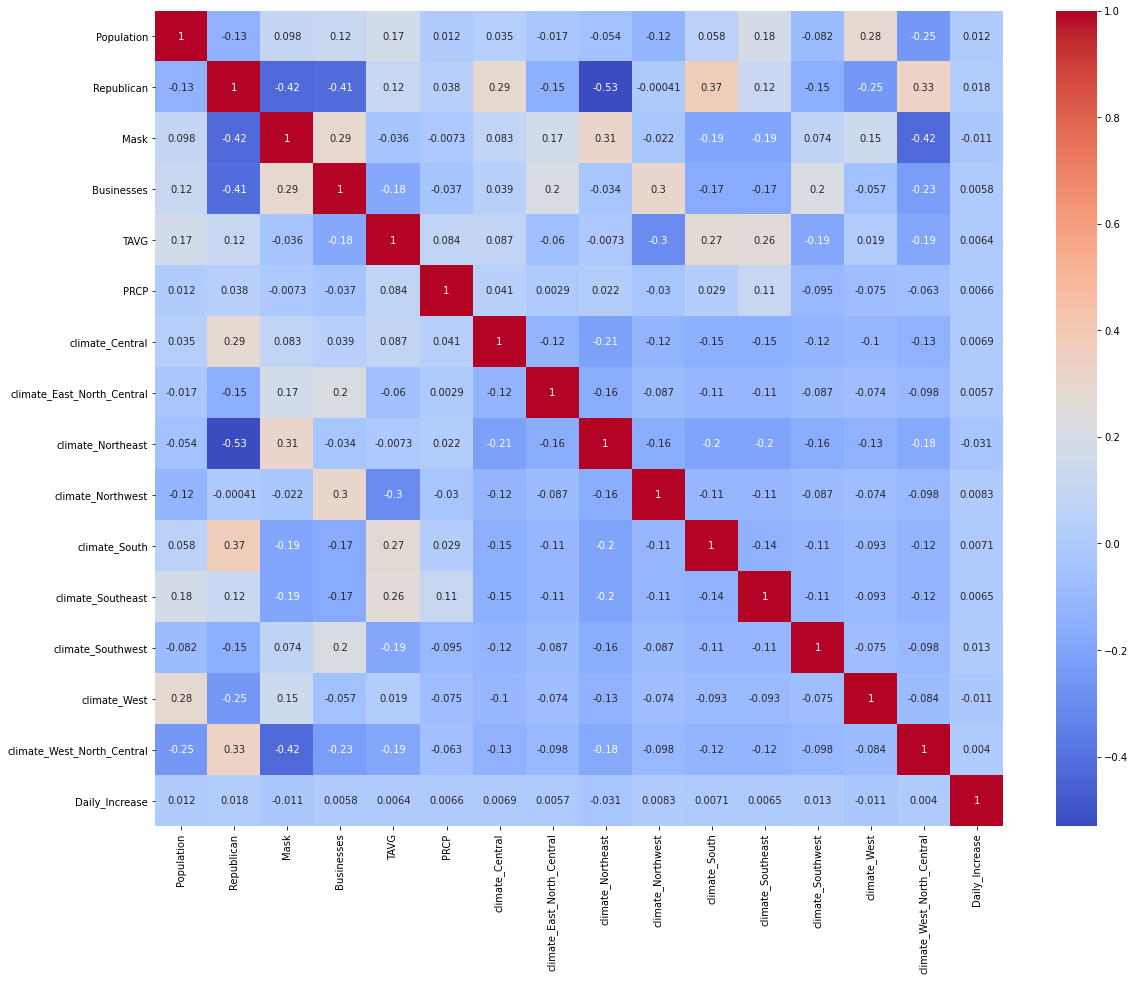

In [ ]:
corrMatrix = all.corr()
print(corrMatrix)
import seaborn as sn
f = plt.figure(figsize=(19, 15))
sn.heatmap(corrMatrix, annot=True, cmap='coolwarm')

In [ ]:
# Bucketizing the continuous
X['TAVG']=pd.qcut(X['TAVG'], 4, labels=[1,2,3,4])
X['PRCP']=pd.qcut(X['PRCP'], 4, labels=[1,2,3],duplicates='drop')
X['Population']=pd.qcut(X['Population'], 4, labels=[1,2,3,4])

In [ ]:
X.head()

,Population,Republican,Mask,Businesses,StayAtHome,TAVG,PRCP,climate_Central,climate_East_North_Central,climate_Northeast,climate_Northwest,climate_South,climate_Southeast,climate_Southwest,climate_West,climate_West_North_Central
2,3,1,2,0,0,2,1,0,0,0,0,0,1,0,0,0
3,3,1,2,0,0,1,1,0,0,0,0,0,1,0,0,0
4,3,1,2,0,0,1,1,0,0,0,0,0,1,0,0,0
5,3,1,2,0,0,2,2,0,0,0,0,0,1,0,0,0
6,3,1,2,0,0,2,3,0,0,0,0,0,1,0,0,0


In [ ]:
#drop 165 and 7 
X=X.drop(axis=1,index=165)
Y=Y.drop(axis=1,index=165)
X=X.drop(axis=1,index=7)
Y=Y.drop(axis=1,index=7)

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y.values.ravel(), test_size=0.3, random_state = 100)

### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

logisticRegr = LogisticRegression()
logisticRegr.fit(x_train, y_train)
y_pred = logisticRegr.predict(x_test)
print('Accuracy of logistic regression classifier on test set: {}'.format(logisticRegr.score(x_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.49948042951160376


In [ ]:
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Precision: 0.47191011235955055
Recall: 0.2391459074733096


In [ ]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.5005195704883962
Mean Squared Error: 0.5005195704883962
Root Mean Squared Error: 0.7074740776087816


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, y_pred))
print('\n')
print("=== All AUC Scores ===")
rfc_cv_score = cross_val_score(logisticRegr, X, Y.values.ravel(), cv=10, scoring='roc_auc')
print(rfc_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", rfc_cv_score.mean())

=== Confusion Matrix ===
[[1106  376]
 [1069  336]]


=== Classification Report ===
              precision    recall  f1-score   support

         0.0       0.51      0.75      0.60      1482
         1.0       0.47      0.24      0.32      1405

    accuracy                           0.50      2887
   macro avg       0.49      0.49      0.46      2887
weighted avg       0.49      0.50      0.46      2887



=== All AUC Scores ===
[0.48306365 0.52945083 0.46579067 0.48877209 0.42490429 0.50504185
 0.46064283 0.50318211 0.52453534 0.5166136 ]


=== Mean AUC Score ===
Mean AUC Score - Random Forest:  0.4901997252501227


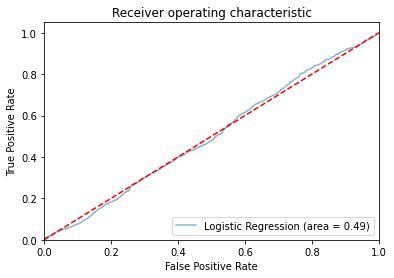

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logisticRegr.predict(x_test))
fpr, tpr, thresholds = roc_curve(y_test, logisticRegr.predict_proba(x_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [ ]:
import statsmodels.api as sm
logit_model=sm.Logit(Y,X)
result=logit_model.fit()
print(result.summary2())

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Optimization terminated successfully.
         Current function value: 0.691767
         Iterations 4
                              Results: Logit
Model:                 Logit               Pseudo R-squared:    0.001     
Dependent Variable:    Daily_Increase      AIC:                 13342.9789
Date:                  2020-12-09 00:44    BIC:                 13457.7262
No. Observations:      9621                Log-Likelihood:      -6655.5   
Df Model:              15                  LL-Null:             -6664.5   
Df Residuals:          9605                LLR p-value:         0.26285   
Converged:             1.0000              Scale:               1.0000    
No. Iterations:        4.0000                                             
--------------------------------------------------------------------------
                            Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
--------------------------------------------------------------------------
Population                  

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

clf=RandomForestClassifier(n_estimators=100)
clf.fit(x_train,y_train)
y_pred=clf.predict(x_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.4904745410460686


In [ ]:
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Precision: 0.47295081967213115
Recall: 0.4106761565836299


In [ ]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.5095254589539314
Mean Squared Error: 0.5095254589539314
Root Mean Squared Error: 0.7138105203441116


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix

print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, y_pred))
print('\n')
print("=== All AUC Scores ===")
rfc_cv_score = cross_val_score(clf, X, Y.values.ravel(), cv=10, scoring='roc_auc')
print(rfc_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", rfc_cv_score.mean())

=== Confusion Matrix ===
[[839 643]
 [828 577]]


=== Classification Report ===
              precision    recall  f1-score   support

         0.0       0.50      0.57      0.53      1482
         1.0       0.47      0.41      0.44      1405

    accuracy                           0.49      2887
   macro avg       0.49      0.49      0.49      2887
weighted avg       0.49      0.49      0.49      2887



=== All AUC Scores ===
[0.48550287 0.48470789 0.47558454 0.46574092 0.43957563 0.44804793
 0.43683516 0.44148899 0.48078188 0.49135574]


=== Mean AUC Score ===
Mean AUC Score - Random Forest:  0.4649621548819952


### KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier()
knn_model.fit(x_train, y_train)
y_pred = knn_model.predict(x_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.4904745410460686


In [ ]:
knn_list =[]
for i in range(1,20):
  knn_model = KNeighborsClassifier(n_neighbors=i)
  knn_model.fit(x_train, y_train)
  y_pred = knn_model.predict(x_test)
  print("Accuracy for k = :",i,'is',metrics.accuracy_score(y_test, y_pred)) 

Accuracy for k = : 1 is 0.49774852788361623
Accuracy for k = : 2 is 0.5043297540699688
Accuracy for k = : 3 is 0.49844128853481123
Accuracy for k = : 4 is 0.4918600623484586
Accuracy for k = : 5 is 0.4904745410460686
Accuracy for k = : 6 is 0.4890890197436786
Accuracy for k = : 7 is 0.4786976099757534
Accuracy for k = : 8 is 0.4786976099757534
Accuracy for k = : 9 is 0.4825077935573259
Accuracy for k = : 10 is 0.4904745410460686
Accuracy for k = : 11 is 0.4811222722549359
Accuracy for k = : 12 is 0.48735711811569105
Accuracy for k = : 13 is 0.4883962590924835
Accuracy for k = : 14 is 0.48804987876688605
Accuracy for k = : 15 is 0.48216141323172845
Accuracy for k = : 16 is 0.48943540006927605
Accuracy for k = : 17 is 0.4797367509525459
Accuracy for k = : 18 is 0.4786976099757534
Accuracy for k = : 19 is 0.48146865258053345


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier(n_neighbors=2)
knn_model.fit(x_train, y_train)
y_pred = knn_model.predict(x_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.5043297540699688


In [ ]:
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Precision: 0.48158640226628896
Recall: 0.24199288256227758


### SVM

In [ ]:
from sklearn import svm
from sklearn import metrics
clf = svm.SVC(kernel='linear') 
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.5025978524419813


In [ ]:
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Precision: 0.4753577106518283
Recall: 0.21281138790035586
